# Libraries and source files

In [ ]:
folder_path = "folder_path..."

# Import

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pickle

from sklearn.metrics import balanced_accuracy_score

# from google.colab import userdata
import google.generativeai as genai
from transformers import BertTokenizer, BertModel

import torch
import torchvision
# import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from PIL import Image

In [91]:
import warnings
warnings.filterwarnings('ignore')

In [92]:
def rescale_image(im):
  if np.max(im) <= 1.0:
    im = im*255
  return im

# Models

## Language model

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [94]:
def move_model_to_cuda(model):
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # print(f"Moving model to {device}")
        try:
            for attr_name in ["transformer", "model", "decoder", "encoder"]:
                if hasattr(model, attr_name):
                    attr = getattr(model, attr_name)
                    if isinstance(attr, torch.nn.ModuleList):
                        for module in attr:
                            module.to(device)
                    elif isinstance(attr, torch.nn.ModuleDict):
                        for module in attr.values():
                            module.to(device)
                    elif isinstance(attr, torch.nn.Module):
                        attr.to(device)
                    else:
                        print(f"Warning: Attribute '{attr_name}' is not a torch.nn.Module.")
            if hasattr(model, "embed_tokens"):
                model.embed_tokens.to(device)
            if hasattr(model, "wte"):
                model.wte.to(device)
            if hasattr(model, "lm_head"):
                model.lm_head.to(device)
            return model
        except Exception as e:
            raise RuntimeError(f"Error moving model to CUDA: {e}")
    else:
        print("CUDA is not available. Keeping model on CPU.")
        return model

In [ ]:
# Set Gemini API key
genai.configure(api_key=Gemini_API_KEY)

language_model = genai.GenerativeModel("gemini-1.5-flash")

# Set Gemini API key
# os.environ["Gemini_API_KEY"] = userdata.get('Gemini_API_KEY')
# genai.configure(api_key=os.environ["Gemini_API_KEY"])

def create_Gen_Model():
  model = genai.GenerativeModel("gemini-1.5-flash")
  if torch.cuda.is_available():
    # print("cuda available!")
    model = move_model_to_cuda(model)
    return model

## BERT

In [96]:
Bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
Bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# if torch.cuda.is_available():
#   print("cuda available!")
#   Bert_model = move_model_to_cuda(Bert_model)

# Data

## Load

In [97]:
DS = "iNaturalist"

In [123]:
testset = torchvision.datasets.INaturalist(root='./data', target_type = 'class', version = '2021_valid',
                                       download=False)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                          shuffle=False, num_workers=2)

In [135]:
from collections import Counter

# Count the number of instances per class in the testset
label_counts = Counter([label for _, label in testset])

# Filter classes with at least 250 instances
sufficient_labels = [label for label, count in label_counts.items() if count >= 250]

# Collect indices for each sufficient class
label_indices = {label: [] for label in sufficient_labels}
for idx, (_, label) in enumerate(testset):
    if label in sufficient_labels:
        label_indices[label].append(idx)

# Sample indices to create a balanced dataset
sampled_indices = []
instances_per_class = 3000 // len(sufficient_labels)
for label in sufficient_labels:
    sampled_indices.extend(np.random.choice(label_indices[label], instances_per_class, replace=False))

# Save the sampled indices
with open(f"{folder_path}/balanced_dataset_indices.pkl", "wb") as f:
    pickle.dump(sampled_indices, f)

In [137]:
len(sampled_indices)

2992

In [148]:
# Shuffle the sampled dataset
sampled_dataset = torch.utils.data.Subset(testset, np.random.permutation(sampled_indices))

In [152]:
len(sampled_dataset)

2992

In [153]:
# original_gt_labels = set()
original_gt_labels_list = []

for test_ints in sampled_dataset:
    original_gt_labels_list.append(test_ints[1])

original_gt_labels = set(original_gt_labels_list)

In [164]:
original_gt_labels_unique_list = list(original_gt_labels)

In [180]:
original_classes = []
for gt_label in original_gt_labels_unique_list:
    class_name = testset.category_name("class", gt_label)
    original_classes.append(class_name.lower())

In [181]:
nr_of_labels = len(original_classes)
known_labels, unknown_labels = tuple(original_gt_labels_unique_list[:int(nr_of_labels/2)]), tuple(original_gt_labels_unique_list[int(nr_of_labels/2):])
known_classes = original_classes[:int(nr_of_labels/2)]
unknown_classes = original_classes[int(nr_of_labels/2):]

known_classes, unknown_classes, known_labels, unknown_labels

(['agaricomycetes',
  'arachnida',
  'bryopsida',
  'insecta',
  'malacostraca',
  'actinopterygii',
  'amphibia',
  'aves'],
 ['mammalia',
  'reptilia',
  'magnoliopsida',
  'pinopsida',
  'polypodiopsida',
  'liliopsida',
  'bivalvia',
  'gastropoda',
  'lecanoromycetes'],
 (33, 2, 37, 6, 7, 9, 10, 12),
 (14, 15, 48, 49, 50, 46, 23, 25, 29))

In [ ]:
# functions to show an image

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % original_classes[labels[j]] for j in range(4)))

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\NYE1BP\Documents\playground\GCD_VQA\.venv\lib\site-packages\torch\utils\data\_utils\worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "c:\Users\NYE1BP\Documents\playground\GCD_VQA\.venv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "c:\Users\NYE1BP\Documents\playground\GCD_VQA\.venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "c:\Users\NYE1BP\Documents\playground\GCD_VQA\.venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 211, in collate
    return [
  File "c:\Users\NYE1BP\Documents\playground\GCD_VQA\.venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "c:\Users\NYE1BP\Documents\playground\GCD_VQA\.venv\lib\site-packages\torch\utils\data\_utils\collate.py", line 240, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>


In [51]:
im = testset[0][0].copy()
image = ToTensor()(im).unsqueeze(0) # unsqueeze to add artificial first dimension
image = image.squeeze(0).permute(1, 2, 0) # transform from 1,3,500,375 to 500,375,3

# 1, 3, 500, 375
# 500, 375, 3

In [58]:
np.max(xx)

np.uint8(255)

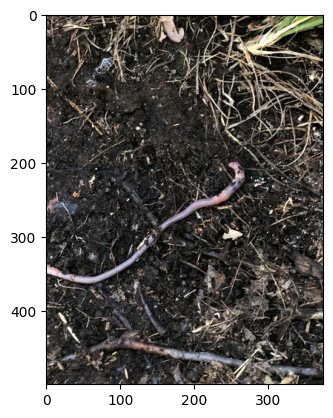

In [57]:
plt.imshow(xx)

6


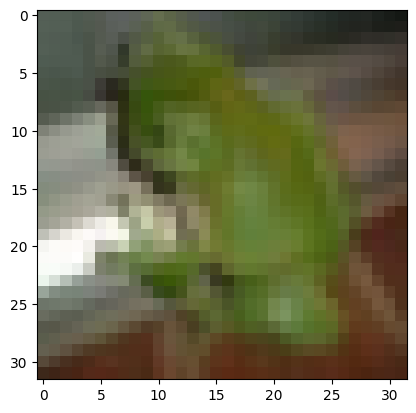

In [15]:
im, label = testset[7]
im = im / 2 + 0.5
# torch_tensor.detach().cpu().numpy()
im = im.detach().cpu().numpy()
im = rescale_image(im).astype(int)
im = np.transpose(im, (1, 2, 0))
print(label)
plt.imshow(im)

In [ ]:
# labels = list()

# for idx in range(2000,3000):
#   labels.append(testset[idx][1])

# np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([103,  89, 123,  96, 101, 105,  91,  93,  99, 100]))

## Embedding

In [168]:
def get_text_embeddings(text):
  inputs = Bert_tokenizer(text, return_tensors='pt')
  inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
  with torch.no_grad():
    outputs = Bert_model(**inputs)
  last_hidden_states = outputs.last_hidden_state
  return last_hidden_states[0][1]

def cosine_similarity(A, B):
  return np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [169]:
known_classes_embed = list()

for c in known_classes:
  known_classes_embed.append(get_text_embeddings(c).cpu())
known_classes_embed = np.array(known_classes_embed)
known_classes_embed.shape

(8, 768)

In [18]:
t = "lizard"
t_embed = get_text_embeddings(t).cpu()

for embed, c in zip(known_classes_embed,known_classes):
  print(f"similarity to {c} is: {cosine_similarity(embed, t_embed)}")

similarity to plane is: 0.7635353803634644
similarity to car is: 0.5777745246887207
similarity to bird is: 0.8145835995674133
similarity to cat is: 0.7883412837982178
similarity to deer is: 0.6125531792640686


In [52]:
t1 = get_text_embeddings('bird').cpu()
t2 = get_text_embeddings('lizard').cpu()
cosine_similarity(t1,t2)

np.float32(0.8145836)

# Experiments

In [170]:

def get_a_category(prompt, image):
  language_model = create_Gen_Model()
  im = Image.fromarray(np.uint8(image)).convert('RGB')
  # input_text = st.text_input(prompt, key="input")
  # input_image = st.image(im, caption="Uploaded Image", use_column_width=True)
  category = language_model.generate_content([prompt, im]).text.strip('\n').strip('.').strip().lower()
  return category

## Benchmark

In [171]:
exp_type = "benchmark"

### One run

In [172]:
prompt_template = "what is the object in the image? answer with one word"

classes = list(known_classes)
novel_label_idx = 10

predicted_classes = list()
novel_classes_labels = dict()

for idx in tqdm(range(10)):
  im, label = sampled_dataset[idx]
  im = np.array(im)
  prompt = prompt_template

  # im = im / 2 + 0.5
  # im = im.detach().cpu().numpy()
  # im = rescale_image(im).astype(int)
  # im = np.transpose(im, (1, 2, 0))

  pred_class = get_a_category(prompt, im)
  predicted_classes.append(pred_class)

  if not(pred_class in classes):
    classes.append(pred_class)
    novel_classes_labels[pred_class] = novel_label_idx
    novel_label_idx += 1

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


In [173]:
np.unique(predicted_classes)

array(['crayfish', 'fungus', 'ladybug', 'moss', 'moth', 'nudibranch',
       'pine', 'shell', 'snake', 'squirrel'], dtype='<U10')

In [ ]:
final_novel_classes_labels = dict()

for k, v in novel_classes_labels.items():
  final_novel_classes_labels[k] = v
  if k in unknown_classes:
    final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]

novel_classes_labels = final_novel_classes_labels.copy()

In [ ]:
novel_classes_labels

{'boat': 10,
 'dinosaur': 11,
 'frog': 6,
 'kitten': 13,
 'jeep': 14,
 'aircraft': 15,
 'truck': 9,
 'dog': 5,
 'horse': 7,
 'alligator': 19,
 'puppy': 20,
 'dhow': 21,
 'arrowhead': 22,
 'dolphin': 23,
 'firetruck': 24,
 'turkey': 25,
 'elk': 26,
 'airplane': 27,
 'emu': 28,
 'automobile': 29,
 'reindeer': 30,
 'koala': 31,
 'dumptruck': 32,
 'tugboat': 33,
 'ship': 8,
 'sailboat': 35,
 'face': 36,
 'chicken': 37,
 'chair': 38,
 'statue': 39,
 'donkey': 40,
 'toad': 41,
 'yacht': 42,
 'train': 43,
 'ferry': 44,
 'convertible': 45,
 'ostrich': 46,
 'skull': 47,
 'moose': 48,
 'scorpion': 49}

In [ ]:
# Known classes accuracy

pred_labels = list()

for pred_class in predicted_classes:
  if pred_class in known_classes:
    pred_labels.append(known_labels[known_classes.index(pred_class)])
  else:
    pred_labels.append(novel_classes_labels[pred_class])

In [ ]:
len(pred_labels)

100

In [ ]:
gt_labels = [testset[idx][1] for idx in tqdm(range(100))]
len(gt_labels)

100%|██████████| 100/100 [00:00<00:00, 1715.96it/s]


100

In [ ]:
pred_labels, gt_labels = np.array(pred_labels), np.array(gt_labels)

In [ ]:
overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
overall_acc

0.4799762737262737

In [ ]:
desiered_items = [l in known_labels for l in gt_labels]
known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
known_acc

0.32857142857142857

In [ ]:
desiered_items = [not(l in known_labels) for l in gt_labels]
unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
unknown_acc

0.6313811188811189

### loop

In [88]:
testset[3]

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=281x500>, 0)

In [187]:
batches = (range(1000), range(1000, 2000), range(2000, len(sampled_dataset)))

# batches_results = list()

for batch in batches[1:]:
# for batch in [range(10)]:

  batch_dict = dict()

  gt_labels = np.array([sampled_dataset[idx][1] for idx in batch])

  prompt_template = "What biological class does the object in the image belong to? Answer with one word, the latin term."

  classes = list(known_classes)
  novel_label_idx = nr_of_labels

  predicted_classes = list()
  novel_classes_labels = dict()

  for idx in tqdm(batch):
    im, label = sampled_dataset[idx]
    prompt = prompt_template

    # im = im / 2 + 0.5
    # im = im.detach().cpu().numpy()
    # im = rescale_image(im).astype(int)
    # im = np.transpose(im, (1, 2, 0))

    im = np.array(im)

    pred_class = get_a_category(prompt, im)
    predicted_classes.append(pred_class)

    if not(pred_class in classes):
      classes.append(pred_class)
      novel_classes_labels[pred_class] = novel_label_idx
      novel_label_idx += 1

  # use correct unknown labels
  final_novel_classes_labels = dict()
  for k, v in novel_classes_labels.items():
    final_novel_classes_labels[k] = v
    if k in unknown_classes:
      final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]
  novel_classes_labels = final_novel_classes_labels.copy()

  # predicted labels list
  pred_labels = list()
  for pred_class in predicted_classes:
    if pred_class in known_classes:
      pred_labels.append(known_labels[known_classes.index(pred_class)])
    else:
      pred_labels.append(novel_classes_labels[pred_class])
  pred_labels = np.array(pred_labels)

  # Accuracy
  # overall
  overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
  # known
  desiered_items = [l in known_labels for l in gt_labels]
  known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
  # unknown
  desiered_items = [not(l in known_labels) for l in gt_labels]
  unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])

  batch_dict["gt_labels"] = gt_labels.copy()
  batch_dict["predicted_classes"] = predicted_classes.copy()
  batch_dict["novel_classes_labels"] = novel_classes_labels.copy()
  batch_dict["pred_labels"] = pred_labels.copy()
  batch_dict["accuracy"] = {"overall":overall_acc,
                            "known":known_acc,
                            "unknown":unknown_acc}

  batches_results.append(batch_dict.copy())

100%|██████████| 992/992 [26:31<00:00,  1.60s/it]  


In [ ]:
# gt_labels = np.array([sampled_dataset[idx][1] for idx in batch])

# prompt_template = "What biological class does the object in the image belong to? Answer with one word, the latin term."

# classes = list(known_classes)
# novel_label_idx = nr_of_labels

# im, label = sampled_dataset[idx]
# prompt = prompt_template

# im = np.array(im)

# pred_class = get_a_category(prompt, im)

# pred_class, classes.index(label)

('mammalia', 14)

#### Average accuracy

In [188]:
overall, known, unknown = 0, 0, 0

for res in batches_results:
  overall += res["accuracy"]["overall"]
  known += res["accuracy"]["known"]
  unknown += res["accuracy"]["unknown"]

num_batches = len(batches_results)

print(f"{exp_type} average accuracy:")
print(f"overall\t: {overall/num_batches}")
print(f"known\t: {known/num_batches}")
print(f"unknown\t: {unknown/num_batches}")

benchmark average accuracy:
overall	: 0.6747888673099379
known	: 0.729775087172662
unknown	: 0.6259122274319608


#### save to drive

In [28]:
import pickle

In [ ]:
with open(f"{folder_path}/{DS}_{exp_type}_batches_results.pkl", "wb") as f:
    pickle.dump(batches_results, f)

In [ ]:
exp_type = "benchmark"

full_dict = {exp_type: np.array(batches_results)}
np.savez_compressed(f"{folder_path}/{DS}/{DS}_{exp_type}.npz", **full_dict)

## Solution 1

In [32]:
exp_type = "solution1"

### One run

In [ ]:
prompt_template = "what is the object in the image? answer with one word"

thr = 0.9

classes = list(known_classes)
novel_label_idx = 10

predicted_classes = list()
novel_classes_labels = dict()
predicted_classes_similarity = list()

for idx in tqdm(range(100)):
  im, label = testset[idx]
  prompt = prompt_template

  im = im / 2 + 0.5
  im = im.detach().cpu().numpy()
  im = rescale_image(im).astype(int)
  im = np.transpose(im, (1, 2, 0))

  pred_class = get_a_category(prompt, im)
  pred_embed = get_text_embeddings(pred_class)
  similarities = [cosine_similarity(embed, pred_embed) for embed in known_classes_embed]
  predicted_classes_similarity.append(similarities)
  max_sim = max(similarities)
  if max_sim >= thr: pred_class=known_classes[similarities.index(max_sim)]

  predicted_classes.append(pred_class)

  if not(pred_class in classes):
    classes.append(pred_class)
    novel_classes_labels[pred_class] = novel_label_idx
    novel_label_idx += 1

  0%|          | 0/100 [00:00<?, ?it/s]2025-01-26 16:37:28.588 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.592 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.595 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.599 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.600 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-26 16:37:28.603 Thread 'MainThread': missing ScriptRunContext! This war

In [ ]:
np.unique(predicted_classes)

array(['alligator', 'asteroid', 'automobile', 'bird', 'boat', 'car',
       'cat', 'chair', 'chicken.', 'convertible', 'deer', 'dhow',
       'dinosaur', 'dog', 'dog.', 'dolphin', 'donkey', 'dumptruck', 'elk',
       'emu', 'face.', 'ferry', 'firetruck', 'frog', 'horse', 'kitten',
       'landrover', 'moose', 'ostrich', 'plane', 'puppy', 'reindeer',
       'sailboat', 'scorpion.', 'sculpture', 'ship', 'toad', 'train',
       'truck', 'tugboat', 'turkey', 'whale', 'yacht'], dtype='<U11')

In [ ]:
novel_label_idx, classes

(48,
 ['plane',
  'car',
  'bird',
  'cat',
  'deer',
  'boat',
  'dinosaur',
  'frog',
  'kitten',
  'landrover',
  'truck',
  'dog',
  'horse',
  'alligator',
  'puppy',
  'dhow',
  'dolphin',
  'firetruck',
  'turkey',
  'elk',
  'emu',
  'automobile',
  'reindeer',
  'dog.',
  'dumptruck',
  'tugboat',
  'ship',
  'sailboat',
  'face.',
  'chicken.',
  'chair',
  'sculpture',
  'donkey',
  'toad',
  'yacht',
  'train',
  'ferry',
  'convertible',
  'ostrich',
  'whale',
  'asteroid',
  'moose',
  'scorpion.'])

In [ ]:
final_novel_classes_labels = dict()

for k, v in novel_classes_labels.items():
  final_novel_classes_labels[k] = v
  if k in unknown_classes:
    final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]

novel_classes_labels = final_novel_classes_labels.copy()

In [ ]:
novel_classes_labels

{'boat': 10,
 'dinosaur': 11,
 'frog': 6,
 'kitten': 13,
 'landrover': 14,
 'truck': 9,
 'dog': 5,
 'horse': 7,
 'alligator': 18,
 'puppy': 19,
 'dhow': 20,
 'dolphin': 21,
 'firetruck': 22,
 'turkey': 23,
 'elk': 24,
 'emu': 25,
 'automobile': 26,
 'reindeer': 27,
 'dog.': 28,
 'dumptruck': 29,
 'tugboat': 30,
 'ship': 8,
 'sailboat': 32,
 'face.': 33,
 'chicken.': 34,
 'chair': 35,
 'sculpture': 36,
 'donkey': 37,
 'toad': 38,
 'yacht': 39,
 'train': 40,
 'ferry': 41,
 'convertible': 42,
 'ostrich': 43,
 'whale': 44,
 'asteroid': 45,
 'moose': 46,
 'scorpion.': 47}

In [ ]:
# Known classes accuracy

pred_labels = list()

for pred_class in predicted_classes:
  if pred_class in known_classes:
    pred_labels.append(known_labels[known_classes.index(pred_class)])
  else:
    pred_labels.append(novel_classes_labels[pred_class])

In [ ]:
len(pred_labels)

100

In [ ]:
gt_labels = [testset[idx][1] for idx in tqdm(range(100))]
len(gt_labels)

100%|██████████| 100/100 [00:00<00:00, 2085.03it/s]


100

In [ ]:
pred_labels, gt_labels = np.array(pred_labels), np.array(gt_labels)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
overall_acc

0.5612262737262738

In [ ]:
desiered_items = [l in known_labels for l in gt_labels]
known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
known_acc

0.5285714285714286

In [ ]:
desiered_items = [not(l in known_labels) for l in gt_labels]
unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
unknown_acc

0.5938811188811189

### loop

In [192]:
batches = (range(1000), range(1000, 2000), range(2000, len(sampled_dataset)))

batches_results = list()

for batch in batches:

  batch_dict = dict()

  gt_labels = np.array([sampled_dataset[idx][1] for idx in batch])

  prompt_template = "What biological class does the object in the image belong to? Answer with one word, the latin term."

  thr = 0.8

  classes = list(known_classes)
  dynamic_classes_embedded = known_classes_embed.copy()
  novel_label_idx = 10

  predicted_classes = list()
  novel_classes_labels = dict()
  predicted_classes_similarity = list()

  for idx in tqdm(batch):
    im, label = sampled_dataset[idx]
    prompt = prompt_template

    # im = im / 2 + 0.5
    # im = im.detach().cpu().numpy()
    # im = rescale_image(im).astype(int)
    # im = np.transpose(im, (1, 2, 0))

    im = np.array(im)

    pred_class = get_a_category(prompt, im)
    pred_embed = get_text_embeddings(pred_class)
    similarities = [cosine_similarity(embed, pred_embed.cpu()) for embed in dynamic_classes_embedded]
    predicted_classes_similarity.append(similarities)
    max_sim = max(similarities)
    if max_sim >= thr: pred_class=classes[similarities.index(max_sim)]

    predicted_classes.append(pred_class)

    if not(pred_class in classes):
      classes.append(pred_class)
      dynamic_classes_embedded = np.vstack([dynamic_classes_embedded, pred_embed.cpu().numpy()])
      novel_classes_labels[pred_class] = novel_label_idx
      novel_label_idx += 1

  # use correct unknown labels
  final_novel_classes_labels = dict()
  for k, v in novel_classes_labels.items():
    final_novel_classes_labels[k] = v
    if k in unknown_classes:
      final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]
  novel_classes_labels = final_novel_classes_labels.copy()

  # predicted labels list
  pred_labels = list()
  for pred_class in predicted_classes:
    if pred_class in known_classes:
      pred_labels.append(known_labels[known_classes.index(pred_class)])
    else:
      pred_labels.append(novel_classes_labels[pred_class])
  pred_labels = np.array(pred_labels)

  # Accuracy
  # overall
  overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
  # known
  desiered_items = [l in known_labels for l in gt_labels]
  known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
  # unknown
  desiered_items = [not(l in known_labels) for l in gt_labels]
  unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])

  batch_dict["gt_labels"] = gt_labels.copy()
  batch_dict["predicted_classes"] = predicted_classes.copy()
  batch_dict["novel_classes_labels"] = novel_classes_labels.copy()
  batch_dict["pred_labels"] = pred_labels.copy()
  batch_dict["similarity"] = predicted_classes_similarity.copy()
  batch_dict["accuracy"] = {"overall":overall_acc,
                            "known":known_acc,
                            "unknown":unknown_acc}

  batches_results.append(batch_dict.copy())

100%|██████████| 992/992 [19:01<00:00,  1.15s/it]


#### Average accuracy

In [194]:
len(batches_results)

3

In [195]:
overall, known, unknown = 0, 0, 0

for res in batches_results:
  overall += res["accuracy"]["overall"]
  known += res["accuracy"]["known"]
  unknown += res["accuracy"]["unknown"]

num_batches = len(batches_results)

print(f"{exp_type} average accuracy:")
print(f"overall\t: {overall/num_batches}")
print(f"known\t: {known/num_batches}")
print(f"unknown\t: {unknown/num_batches}")

benchmark average accuracy:
overall	: 0.7297091815165114
known	: 0.823011028861259
unknown	: 0.6467742060989581


In [196]:
batches_results[0]['novel_classes_labels']

{'mammalia': 14,
 'fungi': 11,
 'pinophyta': 12,
 'reptilia': 15,
 'bivalvia': 23,
 'gastropoda': 25,
 'plantae': 16,
 'magnoliopsida': 48,
 'lichenes': 18,
 'polypodiopsida': 50,
 'mollusca': 20,
 'liliopsida': 46,
 'magnoliophyta': 22,
 'hemiptera': 23,
 'echinodermata': 24,
 'cnidaria': 25,
 'merostomata': 26,
 'isopoda': 27,
 'lycopodiophyta': 28,
 'tracheophyta': 29,
 'pisces': 30,
 'equisetopsida': 31,
 'porifera': 32,
 'juncaceae': 33,
 'minerallia': 34,
 'bryozoa': 35,
 'animalia': 36,
 'basidiomycota': 37,
 'crustacea': 38,
 'ascomycota': 39,
 'lithophyta': 40}

#### save to drive

In [197]:
exp_type = "solution1"

with open(f"{folder_path}/{DS}_{exp_type}_batches_results.pkl", "wb") as f:
    pickle.dump(batches_results, f)

In [ ]:
full_dict = {exp_type: np.array(batches_results)}
np.savez_compressed(f"{folder_path}/{DS}/{DS}_{exp_type}.npz", **full_dict)

## Solution 2

In [198]:
exp_type = "solution2"

### One run

In [55]:
prompt_template = "is the object in the image {list_of_classes}? if not, what is it? answer with one word"

classes = list(known_classes)
novel_label_idx = 10

predicted_classes = list()
novel_classes_labels = dict()

for idx in tqdm(range(100)):
  im, label = testset[idx]
  list_of_classes = "".join(["a "+c+", " for c in classes[:-1]])
  list_of_classes = list_of_classes + f"or a {classes[-1]}"
  prompt = prompt_template.format(list_of_classes=list_of_classes)

  im = im / 2 + 0.5
  im = im.detach().cpu().numpy()
  im = rescale_image(im).astype(int)
  im = np.transpose(im, (1, 2, 0))

  pred_class = get_a_category(prompt, im)
  predicted_classes.append(pred_class)

  if not(pred_class in classes):
    classes.append(pred_class)
    novel_classes_labels[pred_class] = novel_label_idx
    novel_label_idx += 1

 10%|█         | 10/100 [00:04<00:36,  2.44it/s]


KeyboardInterrupt: 

In [ ]:
np.unique(predicted_classes)

array(['alligator', 'bird', 'boat', 'car', 'cat', 'chair', 'deer', 'dog',
       'donkey', 'elk', 'emu', 'firetruck', 'frog', 'horse', 'lizard',
       'monkey', 'otter', 'person', 'plane', 'reindeer', 'sailboat',
       'ship', 'snake', 'squirrel', 'toad', 'truck', 'tugboat', 'turkey',
       'unidentifiable'], dtype='<U14')

In [ ]:
novel_label_idx, classes

(34,
 ['plane',
  'car',
  'bird',
  'cat',
  'deer',
  'boat',
  'frog',
  'truck',
  'dog',
  'horse',
  'alligator',
  'lizard',
  'otter',
  'firetruck',
  'turkey',
  'elk',
  'squirrel',
  'emu',
  'reindeer',
  'snake',
  'ship',
  'sailboat',
  'person',
  'chair',
  'monkey',
  'donkey',
  'toad',
  'tugboat',
  'unidentifiable'])

In [ ]:
final_novel_classes_labels = dict()

for k, v in novel_classes_labels.items():
  final_novel_classes_labels[k] = v
  if k in unknown_classes:
    final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]

novel_classes_labels = final_novel_classes_labels.copy()

In [ ]:
novel_classes_labels

{'boat': 10,
 'frog': 6,
 'truck': 9,
 'dog': 5,
 'horse': 7,
 'alligator': 15,
 'lizard': 16,
 'otter': 17,
 'firetruck': 18,
 'turkey': 19,
 'elk': 20,
 'squirrel': 21,
 'emu': 22,
 'reindeer': 23,
 'snake': 24,
 'ship': 8,
 'sailboat': 26,
 'person': 27,
 'chair': 28,
 'monkey': 29,
 'donkey': 30,
 'toad': 31,
 'tugboat': 32,
 'unidentifiable': 33}

In [ ]:
# Known classes accuracy

pred_labels = list()

for pred_class in predicted_classes:
  if pred_class in known_classes:
    pred_labels.append(known_labels[known_classes.index(pred_class)])
  else:
    pred_labels.append(novel_classes_labels[pred_class])

In [ ]:
len(pred_labels)

100

In [ ]:
gt_labels = [testset[idx][1] for idx in tqdm(range(100))]
len(gt_labels)

100%|██████████| 100/100 [00:00<00:00, 2348.30it/s]


100

In [ ]:
pred_labels, gt_labels = np.array(pred_labels), np.array(gt_labels)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
overall_acc

0.6721003996003996

In [ ]:
desiered_items = [l in known_labels for l in gt_labels]
known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
known_acc

0.6485714285714285

In [ ]:
desiered_items = [not(l in known_labels) for l in gt_labels]
unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
unknown_acc

0.6956293706293707

### loop

In [ ]:
batches = (range(1000), range(1000, 2000), range(2000, len(sampled_dataset)))

# batches_results = list()

for batch in batches:

  batch_dict = dict()

  gt_labels = np.array([sampled_dataset[idx][1] for idx in batch])

  prompt_template = "What biological class does the object in the image belong to, choose from this list: {list_of_classes}. If none fits, add a new category. Avoid plurals, conjugations, synonyms, answer with one word, the latin term."

  classes = list(known_classes)
  novel_label_idx = 10

  predicted_classes = list()
  novel_classes_labels = dict()

  for idx in tqdm(batch):
    im, label = sampled_dataset[idx]
    list_of_classes = "".join(["a "+c+", " for c in classes[:-1]])
    list_of_classes = list_of_classes + f"or a {classes[-1]}"
    prompt = prompt_template.format(list_of_classes=list_of_classes)

    # im = im / 2 + 0.5
    # im = im.detach().cpu().numpy()
    # im = rescale_image(im).astype(int)
    # im = np.transpose(im, (1, 2, 0))

    im = np.array(im)

    pred_class = get_a_category(prompt, im)
    predicted_classes.append(pred_class)

    if not(pred_class in classes):
      classes.append(pred_class)
      novel_classes_labels[pred_class] = novel_label_idx
      novel_label_idx += 1

  # use correct unknown labels
  final_novel_classes_labels = dict()
  for k, v in novel_classes_labels.items():
    final_novel_classes_labels[k] = v
    if k in unknown_classes:
      final_novel_classes_labels[k] = unknown_labels[unknown_classes.index(k)]
  novel_classes_labels = final_novel_classes_labels.copy()

  # predicted labels list
  pred_labels = list()
  for pred_class in predicted_classes:
    if pred_class in known_classes:
      pred_labels.append(known_labels[known_classes.index(pred_class)])
    else:
      pred_labels.append(novel_classes_labels[pred_class])
  pred_labels = np.array(pred_labels)

  # Accuracy
  # overall
  overall_acc = balanced_accuracy_score(gt_labels, pred_labels)
  # known
  desiered_items = [l in known_labels for l in gt_labels]
  known_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])
  # unknown
  desiered_items = [not(l in known_labels) for l in gt_labels]
  unknown_acc = balanced_accuracy_score(gt_labels[desiered_items], pred_labels[desiered_items])

  batch_dict["gt_labels"] = gt_labels.copy()
  batch_dict["predicted_classes"] = predicted_classes.copy()
  batch_dict["novel_classes_labels"] = novel_classes_labels.copy()
  batch_dict["pred_labels"] = pred_labels.copy()
  batch_dict["accuracy"] = {"overall":overall_acc,
                            "known":known_acc,
                            "unknown":unknown_acc}

  batches_results.append(batch_dict.copy())

 16%|█▋        | 165/1000 [03:08<11:00,  1.26it/s]

#### Average accuracy

In [ ]:
overall, known, unknown = 0, 0, 0

for res in batches_results:
  overall += res["accuracy"]["overall"]
  known += res["accuracy"]["known"]
  unknown += res["accuracy"]["unknown"]

num_batches = len(batches_results)

print(f"{exp_type} average accuracy:")
print(f"overall\t: {overall/num_batches}")
print(f"known\t: {known/num_batches}")
print(f"unknown\t: {unknown/num_batches}")

solution2 average accuracy:
overall	: 0.709023490604416
known	: 0.777684122766981
unknown	: 0.6403628584418514


In [90]:
batches_results[0]['novel_classes_labels']

{'boat': 10,
 'lizard': 11,
 'truck': 9,
 'dog': 5,
 'horse': 7,
 'frog': 6,
 'donkey': 16,
 'owl': 17,
 'goat': 18,
 'building': 19,
 'ostrich': 20,
 'submarine': 21,
 'fish': 22,
 'rock': 23,
 'moose': 24}

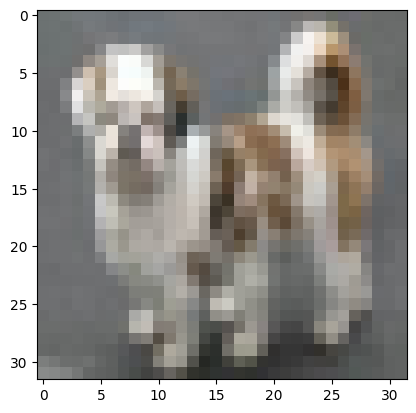

In [73]:
im = testset[1041][0]
im = im / 2 + 0.5
im = im.detach().cpu().numpy()
im = rescale_image(im).astype(int)
im = np.transpose(im, (1, 2, 0))
plt.imshow(im)

In [84]:
prompt = "What is depicted on the image, choose from this list: bird, a bunny, a car. If none fits, add a new category. Avoid plurals, conjugations, synonyms and answer with a single word."
pred_class = get_a_category(prompt, im)

In [85]:
pred_class

'dog'

In [ ]:
batches_results[1]['']

array([ 5,  0, 11,  4,  8,  1,  1, 13,  9,  6,  0,  8,  6,  1,  3,  4,  1,
       16,  0,  5,  1,  1, 17, 17, 18,  5, 19, 17, 20,  6,  3,  3, 20,  3,
        6,  6, 17,  7,  2,  2,  2, 22, 20, 23,  8,  5,  2,  1,  1,  4,  3,
        2, 17,  3,  1,  5, 20,  7,  6,  8,  9,  1,  6,  4, 24,  3,  1, 17,
        9,  6,  3,  6, 17,  7,  3,  8, 17, 17, 17,  6,  6,  6, 25,  2,  5,
        4,  4, 20, 20,  6, 26, 11,  6, 17,  6, 20,  7,  5,  1,  2,  7,  8,
        8, 17, 27,  5, 28,  7, 23, 17,  2,  8,  3,  8, 27,  1,  5,  5, 23,
        7, 23, 20,  8,  3,  3, 19,  2,  8, 23,  5,  7, 29, 20, 20,  1,  6,
        9, 30,  5,  8, 20,  1, 11,  6,  1, 23, 23,  6,  2,  7,  2,  2, 17,
        8, 19,  9,  1, 31,  1,  8, 11, 17,  7,  3, 32, 33,  3, 34,  3,  7,
        7,  9, 35, 20,  1,  9,  1,  9,  6,  3,  3,  3,  1, 17, 20,  1, 34,
        1, 17, 17,  1,  9,  6,  5,  4,  6, 23,  9,  7,  9, 11,  7,  2, 17,
        6, 11,  1,  4,  3,  7, 17, 20,  1, 11,  5,  7, 11,  4,  8,  3,  9,
       29,  9,  8,  7,  6

In [60]:
batches_results[1]['novel_classes_labels']

{'dog': 5,
 'boat': 11,
 'ship': 8,
 'fish': 13,
 'truck': 9,
 'frog': 6,
 'fox': 16,
 'airplane': 17,
 'hand': 18,
 'lizard': 19,
 'unidentifiable': 20,
 'horse': 7,
 'dogs': 22,
 'ostrich': 23,
 'mailbox': 24,
 'towtruck': 25,
 'seaplane': 26,
 'firetruck': 27,
 'bus': 28,
 'van': 29,
 'boot': 30,
 'unicorn': 31,
 'sailboat': 32,
 'clouds': 33,
 'moose': 34,
 'bear': 35,
 'mushrooms': 36,
 'parrot': 37,
 'tugboat': 38,
 'jet-ski': 39,
 'elk': 40,
 'keyboard': 41,
 'shark': 42,
 'llama': 43,
 'rooster': 44,
 'squirrel': 45,
 'caribou': 46,
 'stairs': 47,
 'rabbit': 48,
 'people': 49,
 'donut': 50,
 'flamingo': 51,
 'policecar': 52,
 'helicopter': 53,
 'monkey': 54,
 'cats': 55,
 'elephant': 56,
 'trailer': 57,
 'hat': 58,
 'generator': 59,
 'cassowary': 60,
 'bridge': 61,
 'sheep': 62,
 'kangaroo': 63}

#### save to drive

In [ ]:
exp_type = "solution2"

with open(f"{folder_path}/{DS}_{exp_type}_batches_results_new_prompt.pkl", "wb") as f:
    pickle.dump(batches_results, f)

In [ ]:
full_dict = {exp_type: np.array(batches_results)}
np.savez_compressed(f"{folder_path}/{DS}/{DS}_{exp_type}.npz", **full_dict)